In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

from agentfil import plot_utils

import copy

In [3]:
purples = mpl.colormaps['Purples']
blues = mpl.colormaps['Blues']
greens = mpl.colormaps['Greens']
oranges = mpl.colormaps['Oranges']
reds = mpl.colormaps['Reds']

In [4]:
colors = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

results_root_dir=os.path.join(os.environ['HOME'],'agentfil','sdm')

filp_agent_discount_rate = 25
cc_agent_discount_rate_multipler = 2
rational_agent_type='NPVAgent'
sdm_slope=0.285

# Control Experiment
normal_cc_agent_discount_rate = filp_agent_discount_rate * cc_agent_discount_rate_multipler
cfg_tuple = (sdm_slope, filp_agent_discount_rate, normal_cc_agent_discount_rate)
label_tuple = (filp_agent_discount_rate, normal_cc_agent_discount_rate)
experiment_dirs = [
    "SDMBaseline_%0.03f,FILP_4,%d,0.50,CC_4,%d,Onboard_6.00,RR_0.60,DR_10" % cfg_tuple,
    "SDMBaseline_%0.03f,FILP_4,%d,0.50,CC_4,%d,Onboard_6.00,RR_0.60,DR_20" % cfg_tuple,
    "SDMBaseline_%0.03f,FILP_4,%d,0.50,CC_4,%d,Onboard_6.00,RR_0.60,DR_30" % cfg_tuple,
]
experiment_names = [
    '10%', '20%', '30%'
]

baseline_fpr = 0.8
baseline_sector_duration = 360
baseline_folder = os.path.join(os.environ['HOME'],'agentfil','baseline')
baseline_experiment = 'BaselineDCA_RBP_%0.02f-RR_%0.02f-FPR_%0.02f-Dur_%0.02f' % \
                (6, 0.6, baseline_fpr, baseline_sector_duration)
baseline_filecoin_df = pd.read_csv(os.path.join(baseline_folder, baseline_experiment, 'filecoin_df.csv'))


# plot settings
min_agent_plot_date = date(2023, 4, 1)
max_agent_plot_date = date(2026, 12, 31)

min_kpi_plot_date = None
max_kpi_plot_date = date(2026, 12, 31)

save_dir = os.path.join('/Users/kiran/Documents/ced_austin')

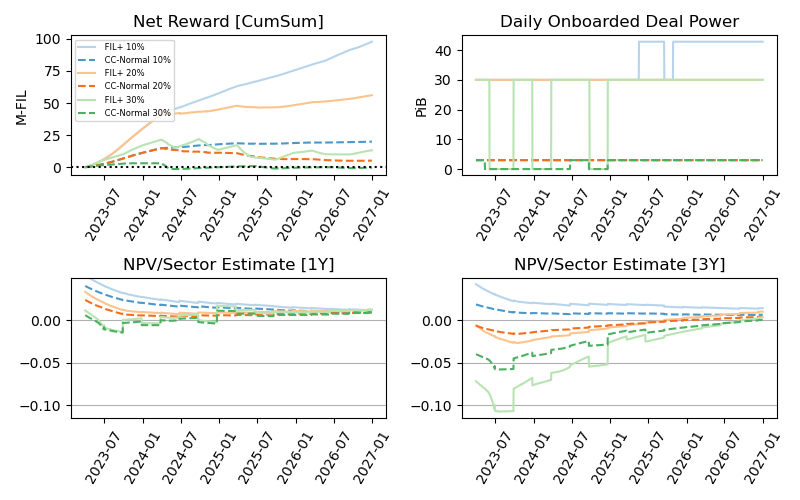

In [13]:
plt.figure(figsize=(8,5))

plt_kwargs_list = [
    [{'color': blues(0.3)}, {'color': blues(0.6), 'linestyle':'--'}, {'color': blues(0.8), 'linestyle':':'}],
    [{'color': oranges(0.3)}, {'color': oranges(0.6), 'linestyle':'--'}, {'color': oranges(0.8), 'linestyle':':'}],
    [{'color': greens(0.3)}, {'color': greens(0.6), 'linestyle':'--'}, {'color': greens(0.8), 'linestyle':':'}],
]
per_agent_label_list = ['FIL+', 'CC-Normal', 'CC-RiskAverse']


plt.subplot(2,2,1)
keys = ['reward_FIL', 'pledge_interest_payment_FIL']
def compute_net_reward_FIL(key_data):
    net_reward_FIL = key_data['reward_FIL'].cumsum() - key_data['pledge_interest_payment_FIL'].cumsum()
    return net_reward_FIL/1_000_000
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=compute_net_reward_FIL, 
               df_name='accounting_df', 
               label_postpend=exp_name, 
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('Net Reward [CumSum]')
plt.ylabel('M-FIL')
plt.legend(fontsize=6)
plt.axhline(0, color='k', linestyle=':')

plt.subplot(2,2,2)
def compute_deal_onboarded(key_data):
    total_onboards = key_data['deal_onboarded']
    return total_onboards
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['cc_onboarded', 'cc_renewed', 'deal_onboarded'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=compute_deal_onboarded, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('Daily Onboarded Deal Power')
plt.ylabel('PiB')

plt.subplot(2,2,3)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_365'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('NPV/Sector Estimate [1Y]')
ax1 = plt.gca()
ax1.yaxis.grid()

plt.subplot(2,2,4)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_1095'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('NPV/Sector Estimate [3Y]')
ax2 = plt.gca()
ax1.sharey(ax2)
ax2.yaxis.grid()

# plt.suptitle('FILSupplyDiscountRate=%0.02f' % \
#              (fil_supply_discount_rate,))

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'exp2.png'))

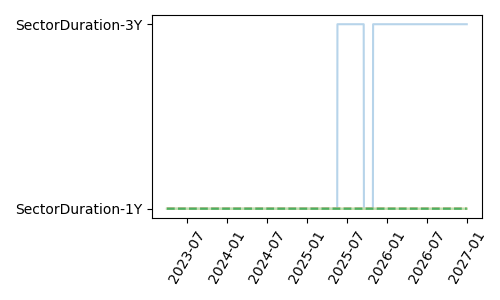

In [16]:
def get_selected_yr(key_data):
    npv_df = pd.DataFrame()
    npv_df['SectorDuration-1Y'] = key_data['npv_estimate_365']
    npv_df['SectorDuration-3Y'] = key_data['npv_estimate_1095']
    yr_select = npv_df.idxmax(axis=1)
    
    return yr_select

plt.figure(figsize=(5,3))
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_365', 'npv_estimate_1095'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=get_selected_yr, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
# plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'exp2_duration_selection.png'))